In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz, lil_matrix, csr_matrix

import copy
import datetime
import os
import time
import scipy.sparse as sp
import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import matplotlib.colors as clr
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy.io
import h5py
import json
import torch
import numpy as np
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_3'

In [2]:
cluster_colors=['#4b6aa8','#3ca0cf','#c376a7','#ad98c3','#408444',
                '#53738c','#a25087','#a78982','#a9c2cb','#92699e',
                '#d69971','#df5734','#6c408e','#ac6894','#d4c2db',
                '#537eb7','#83ab8e','#ece399','#405993','#cc7f73',
                '#b95055','#d5bb72','#bc9a7f','#e0cfda','#d8a0c0',
                '#e6b884','#b05545','#d69a55','#64a776','#cbdaa9',
                '#efd2c9','#da6f6d','#ebb1a4','#a44e89','#8c564b',
                '#b85292','#6d6fa0','#8d689d','#c8c7e1','#d25774',
                '#c49abc','#a5a9b0','#927c9a','#9f8d89','#72567a',
                '#63a3b8','#c4daec','#61bada','#b7deea','#e29eaf',
                '#4490c4','#e6e2a3','#de8b36','#c4612f','#9a70a8',
                '#76a2be','#cea5c7','#c6adb0','#9d3b62','#2d3462', 
                '#FF420E','#FFBB00']

In [3]:
path = './results/mouse_1/2024_04_08_20_10_00GATE_2encoder_cat_feature_decoder_skip_connect_bn/'
adata = sc.read_h5ad(path + 'feature_add_weight1/Clusters_res0.75/adata_cluster_feature.h5ad')
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/data/mouse_1/allen_region.csv')
adata.obs['region'] = allen_region['region'].to_list()
adata

AnnData object with n_obs × n_vars = 250535 × 1122
    obs: 'x_section_mean', 'x', 'y', 'z', 'section', 'NT_index', 'Cells_id', 'clusters', 'region'
    var: 'gene_identifier', 'name', 'mapped_ncbi_identifier'
    uns: 'clusters_colors', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'GATE_feature_add', 'GATE_feature_con', 'GATE_feature_spa', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obsm['spatial'] = adata.obs[['z', 'y']].values

### PLS

#### th gene

In [5]:
adata = adata[adata.obs['z'] < 56]

In [126]:
cluster = '11'
sec = 'Zhuang-ABCA-1.093'

In [127]:
th_regions = ['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'IAD', 'IAM', 'IGL', 'IMD', 'LD', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL',
                'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi']
adata.obs['th_cluster'] = adata.obs['clusters'].astype(str)
adata.obs.loc[~(adata.obs['region'].isin(th_regions)), 'th_cluster'] = '-1'
# adata.obs

In [128]:
# 2. 准备数据
# X = adata.layers['adj_gene'].A  # 基因表达矩阵
X = adata.X.A  # 基因表达矩阵
y = adata.obs['th_cluster'].values  # 类别标签
# 3. 标准化数据
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X
# 将类别标签转换为二分类问题，假设类别1为1，其它类别为0
y_binary = np.where(y == cluster, 1, 0)

# 4. 建立PLS模型
pls = PLSRegression(n_components=10)  # 你可以调整n_components
pls.fit(X, y_binary)

# 5. 分析结果
# PLS系数可以帮助你找出重要的基因
coefficients = pls.coef_.flatten()
# coefficients = np.abs(pls.coef_.ravel())

gene_names = adata.var_names
th_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [129]:
# 计算重要性的平均值和标准差
importance_mean = th_gene_importance['Importance'].mean()
importance_std = th_gene_importance['Importance'].std()
# 设置阈值为平均值加上一个标准差
# threshold = importance_mean + importance_std
# threshold = th_gene_importance['Importance'].quantile(0.97)
# 选择重要性高于阈值的基因
# th_genes = th_gene_importance[th_gene_importance['Importance'] > threshold]
th_genes = th_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# 按重要性降序排序
th_genes = th_genes.sort_values('Importance', ascending=False)

# 只使用选定的基因重新计算加权表达
X_selected = X[:, [list(gene_names).index(gene) for gene in th_genes['Gene']]]
coefficients_selected = th_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# 将加权表达向量添加到原始数据中
scaler = StandardScaler()
adata.obs['th_Expression'] = scaler.fit_transform(weighted_expression.reshape(-1, 1))
# th_genes.to_csv(f'./th_ctx_cluster_gene/cluster{cluster}_th_gene.csv')
th_genes

,Gene,Coefficient,Importance
566,Gbx2,0.003416,0.003416
1002,Tnnt1,0.002547,0.002547
316,Rgs16,0.002258,0.002258
72,Grid2ip,0.002062,0.002062
318,Cnih3,-0.001923,0.001923
1079,Abhd12b,-0.001762,0.001762
73,Vipr2,0.001742,0.001742
1007,Plekhd1,0.001628,0.001628
199,Prkcd,0.001527,0.001527
495,Cbln1,-0.001472,0.001472


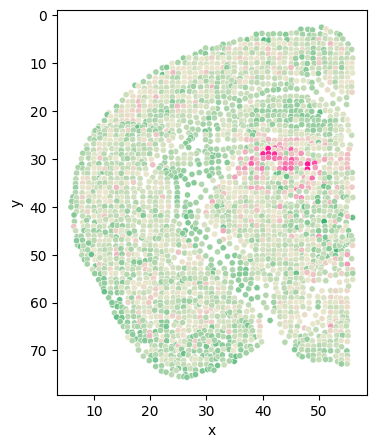

In [109]:
# sec = 'Zhuang-ABCA-1.089'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['th_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  # 展平为一维数组
    'expression': adata_s.obs['th_Expression']  # 展平为一维数组
})
# 创建散点图
plt.figure(figsize=(4, 5))  # 调整为所需的图像大小
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False)  # 's' 为点的大小
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

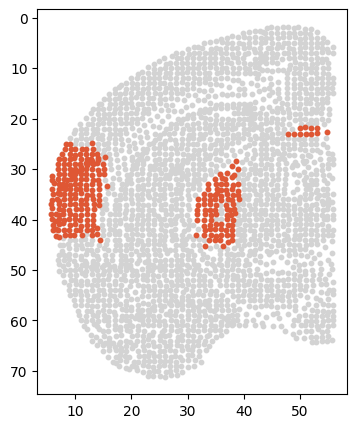

In [44]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
# back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=10, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=10, c=cluster_colors[int(cluster)])
plt.gca().invert_yaxis()

#### ctx gene

In [130]:
ctx_regions = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo',
                'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm',
                'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd',
                'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs',
                'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
                'VISpl', 'VISpm', 'VISpor', 'VISrl']
adata.obs['ctx_cluster'] = adata.obs['clusters'].astype(str)
adata.obs.loc[~(adata.obs['region'].str.startswith(tuple(ctx_regions))), 'ctx_cluster'] = '-1'
# adata.obs

In [131]:
# 2. 准备数据
# X = adata.layers['adj_gene'].A  # 基因表达矩阵
X = adata.X.A  # 基因表达矩阵
y = adata.obs['ctx_cluster'].values  # 类别标签
# 3. 标准化数据
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X
# 将类别标签转换为二分类问题，假设类别1为1，其它类别为0
y_binary = np.where(y == cluster, 1, 0)

# 4. 建立PLS模型
pls = PLSRegression(n_components=10)  # 你可以调整n_components
pls.fit(X, y_binary)

# 5. 分析结果
# PLS系数可以帮助你找出重要的基因
coefficients = pls.coef_.flatten()
# coefficients = np.abs(pls.coef_.ravel())

gene_names = adata.var_names
ctx_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [119]:
# # 得分图
# scores = pls.transform(X)  # 获取PLS得分
# plt.figure(figsize=(12, 6))
# plt.scatter(scores[:, 0], scores[:, 2], c=y_binary.astype(int), cmap='Spectral_r', alpha=0.5)
# plt.xlabel('PLS Component 1')
# plt.ylabel('PLS Component 2')
# plt.title('PLS Score Plot')
# plt.colorbar(label='Category')
# plt.show()

In [132]:
# 计算重要性的平均值和标准差
importance_mean = ctx_gene_importance['Importance'].mean()
importance_std = ctx_gene_importance['Importance'].std()
# 设置阈值为平均值加上一个标准差
# threshold = importance_mean + importance_std
# threshold = ctx_gene_importance['Importance'].quantile(0.97)
# 选择重要性高于阈值的基因
# ctx_genes = ctx_gene_importance[ctx_gene_importance['Importance'] > threshold]
ctx_genes =  ctx_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# 按重要性降序排序
ctx_genes = ctx_genes.sort_values('Importance', ascending=False)

# 只使用选定的基因重新计算加权表达
X_selected = X[:, [list(gene_names).index(gene) for gene in ctx_genes['Gene']]]
coefficients_selected = ctx_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# 将加权表达向量添加到原始数据中
scaler = StandardScaler()
adata.obs['ctx_Expression'] = X_scaled = scaler.fit_transform(weighted_expression.reshape(-1, 1))
# ctx_genes.to_csv(f'./th_ctx_cluster_gene/cluster{cluster}_ctx_gene.csv')
ctx_genes

,Gene,Coefficient,Importance
334,Nr4a2,0.009431,0.009431
886,Igfn1,-0.007870,0.007870
1053,Rprm,0.006268,0.006268
929,Synpr,0.006225,0.006225
1015,Gpr88,0.005867,0.005867
1040,Kcng1,-0.005755,0.005755
818,Ankfn1,0.005611,0.005611
308,Lypd1,0.005590,0.005590
385,Adgrl2,-0.005482,0.005482
63,Tcap,0.005284,0.005284


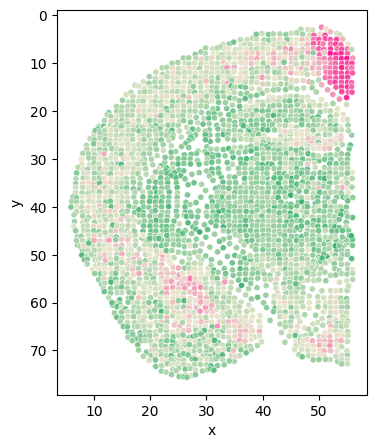

In [113]:
# sec =  'Zhuang-ABCA-1.089'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['ctx_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  # 展平为一维数组
    'expression': adata_s.obs['ctx_Expression']  # 展平为一维数组
})
# 创建散点图
plt.figure(figsize=(4, 5))  # 调整为所需的图像大小
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False)  # 's' 为点的大小
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

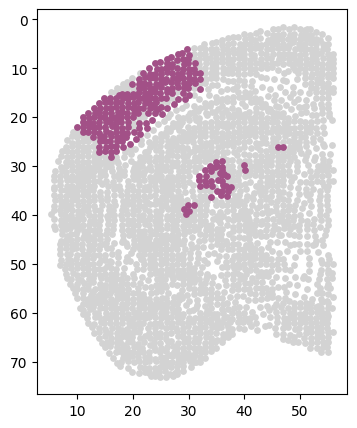

In [204]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=15, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=15, c=cluster_colors[int(cluster)])
plt.gca().invert_yaxis()

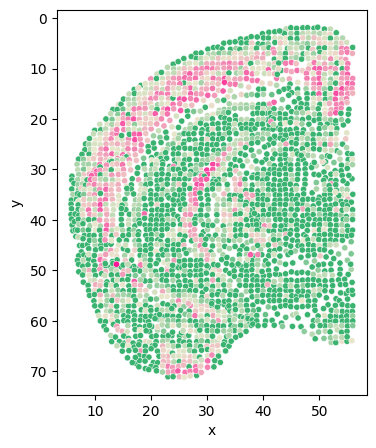

In [136]:
adata.obs['ctx_th_Expression'] = adata.obs['ctx_Expression'] + adata.obs['th_Expression']
adata_s = adata[adata.obs['section'] == sec]
df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    'expression': adata_s[:, 'Trhde'].X.A.flatten()
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  # 展平为一维数组
    # 'expression': adata_s.obs['ctx_th_Expression']  # 展平为一维数组
})
# 创建散点图
plt.figure(figsize=(4, 5))  # 调整为所需的图像大小
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False)  # 's' 为点的大小
plt.gca().invert_yaxis()

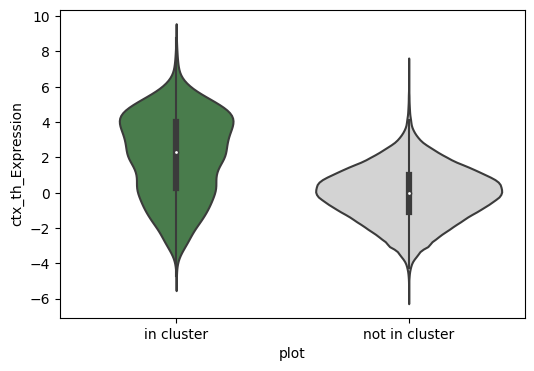

In [115]:
tmp_df = adata.obs[['ctx_th_Expression', 'clusters']]
tmp_df['plot'] = 'not in cluster'
tmp_df.loc[tmp_df['clusters'] == cluster, 'plot'] = 'in cluster'

means = tmp_df.groupby('plot')['ctx_th_Expression'].mean()
# 绘制小提琴图
plt.figure(figsize=(6, 4))
sns.violinplot(data=tmp_df, x='plot', y='ctx_th_Expression', 
               palette=[cluster_colors[int(cluster)], '#d3d3d3'],order=['in cluster', 'not in cluster'])
plt.savefig(f'./th_ctx_cluster_gene/cluster{cluster}.pdf', format = 'pdf')

#### th_ctx_compare

 clusters gene compare

In [214]:
c4 = pd.read_csv('./th_ctx_cluster_gene/cluster4_th_ctx_gene.csv')
c11 = pd.read_csv('./th_ctx_cluster_gene/cluster11_th_ctx_gene.csv')
c34 = pd.read_csv('./th_ctx_cluster_gene/cluster34_th_ctx_gene.csv')

In [31]:
genes_a = c4.columns.tolist()
genes_b = c11.columns.tolist()
genes_c = c34.columns.tolist()
# 使用 pandas 创建一个 DataFrame
data = {
    'A': genes_a,
    'B': genes_b,
    'C': genes_c
}
# 使用 pandas 创建一个 DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))
df.to_excel('./ctx_cc_cluster/gene.xlsx')

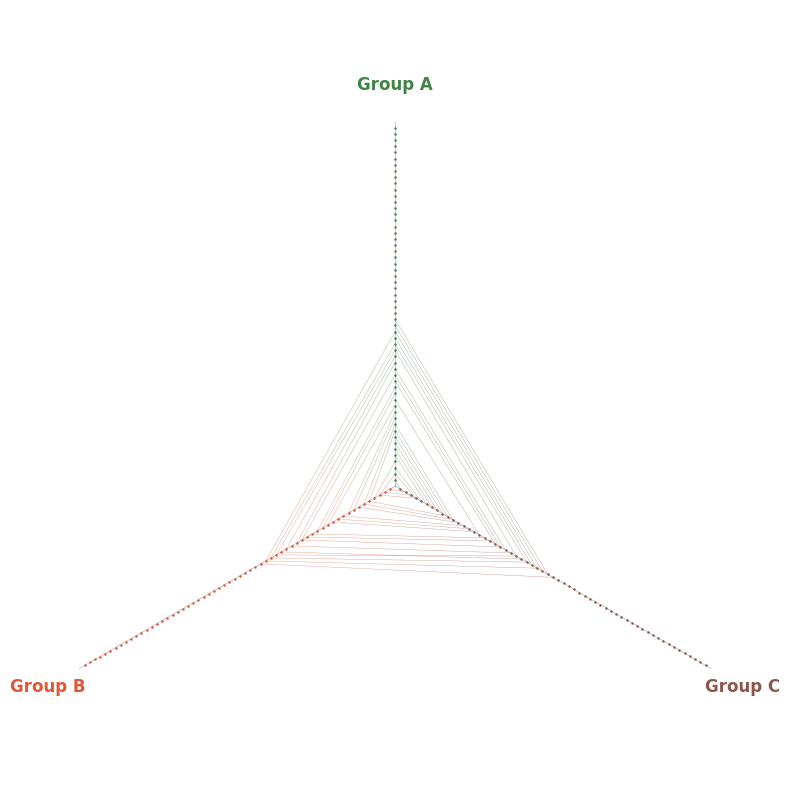

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections as mc
from matplotlib.colors import LinearSegmentedColormap
genes_a = c4.columns.tolist()
genes_b = c11.columns.tolist()
genes_c = c34.columns.tolist()

def reorder_genes(group, other_groups):
    shared = set(group) & set(sum(other_groups, []))
    unique = set(group) - shared
    return list(shared) + list(unique)

# 重新排序每组基因
genes_a = reorder_genes(genes_a, [genes_b, genes_c])
genes_b = reorder_genes(genes_b, [genes_a, genes_c])
genes_c = reorder_genes(genes_c, [genes_a, genes_b])

# 设置图形
fig, ax = plt.subplots(figsize=(8, 8))

# 计算每条线的角度（弧度）
angles = [0+np.pi/2, 2*np.pi/3+np.pi/2, 4*np.pi/3+np.pi/2]

# 设置线的长度
length = 10

# 绘制三条线
for angle in angles:
    x = [0, length * np.cos(angle)]
    y = [0, length * np.sin(angle)]
    ax.plot(x, y, 'k-', alpha=0.3, linewidth=0.5)

# 定义颜色
colors = ['#408444', '#df5734', '#8c564b']
color_dict = {'A': colors[0], 'B': colors[1], 'C': colors[2]}

# 用于存储每个基因的坐标
gene_positions = {group: {} for group in ['A', 'B', 'C']}

# 在每条线上添加点
for i, (angle, genes, color, group) in enumerate(zip(angles, [genes_a, genes_b, genes_c], colors, ['A', 'B', 'C'])):
    num_genes = len(genes)
    for j, gene in enumerate(genes):
        # 计算点的位置
        distance = length * (j + 1) / (num_genes + 1)
        x = distance * np.cos(angle)
        y = distance * np.sin(angle)
        
        # 绘制点
        ax.plot(x, y, 'o', markersize=0.8, color=color)
        
        # 存储基因位置
        gene_positions[group][gene] = (x, y)

# 创建渐变色函数
def get_gradient_color(color1, color2):
    return LinearSegmentedColormap.from_list("", [color1, color2])

# 连接相同的基因
all_genes = set(genes_a + genes_b + genes_c)
for gene in all_genes:
    positions = []
    groups = []
    for group in ['A', 'B', 'C']:
        if gene in gene_positions[group]:
            positions.append(gene_positions[group][gene])
            groups.append(group)
    
    if len(positions) > 1:
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                x1, y1 = positions[i]
                x2, y2 = positions[j]
                color1 = color_dict[groups[i]]
                color2 = color_dict[groups[j]]
                gradient_color = get_gradient_color(color1, color2)
                
                # 使用渐变色绘制线
                x = np.linspace(x1, x2, 100)
                y = np.linspace(y1, y2, 100)
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = mc.LineCollection(segments, cmap=gradient_color, alpha=0.7, linewidths=0.25)
                lc.set_array(np.linspace(0, 1, len(segments)))
                ax.add_collection(lc)

# 设置坐标轴
ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)
ax.axis('off')
ax.axis('equal')

# 添加组标签
group_labels = ['Group A', 'Group B', 'Group C']
for angle, label, color in zip(angles, group_labels, colors):
    x = length * 1.1 * np.cos(angle)
    y = length * 1.1 * np.sin(angle)
    ax.text(x, y, label, fontsize=12, fontweight='bold',
            ha='center', va='center', color=color)

# 设置标题
# plt.title("Gene Distribution and Shared Genes Across Groups", fontsize=16)

# 显示图形
plt.tight_layout()
plt.savefig('./th_ctx_cluster_gene/gene_3.pdf', format='pdf')

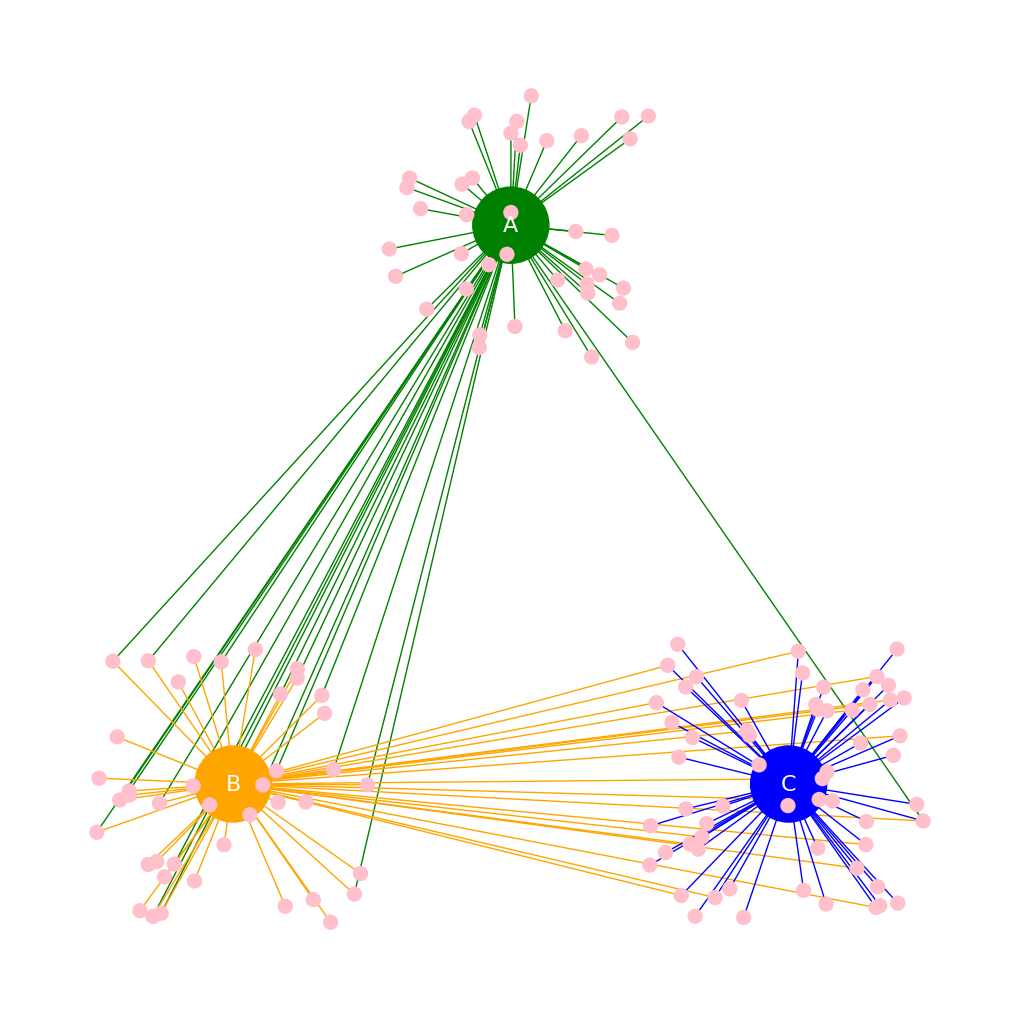

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# 示例基因集
random.seed(123)
genes_A = [f"Gene_{i}" for i in random.sample(range(1, 101), 60)]
genes_B = [f"Gene_{i}" for i in random.sample(range(50, 151), 60)]
genes_C = [f"Gene_{i}" for i in random.sample(range(100, 201), 60)]
# 创建一个无向图
G = nx.Graph()

# 添加中心节点
G.add_node("A", pos=(0, 1), size=3000, color='green')
G.add_node("B", pos=(-1, -1), size=3000, color='orange')
G.add_node("C", pos=(1, -1), size=3000, color='blue')

# 添加基因节点和连接边
for gene in genes_A:
    G.add_node(gene, pos=(random.uniform(-0.5, 0.5), random.uniform(0.5, 1.5)), size=100, color='pink')
    G.add_edge("A", gene, color='green')
    
for gene in genes_B:
    G.add_node(gene, pos=(random.uniform(-1.5, -0.5), random.uniform(-1.5, -0.5)), size=100, color='pink')
    G.add_edge("B", gene, color='orange')

for gene in genes_C:
    G.add_node(gene, pos=(random.uniform(0.5, 1.5), random.uniform(-1.5, -0.5)), size=100, color='pink')
    G.add_edge("C", gene, color='blue')

# 添加共享基因连接
shared_AB = set(genes_A) & set(genes_B)
shared_AC = set(genes_A) & set(genes_C)
shared_BC = set(genes_B) & set(genes_C)
shared_ABC = shared_AB & shared_AC & shared_BC

for gene in shared_AB:
    G.add_edge("A", gene, color='green')
    G.add_edge("B", gene, color='orange')
    
for gene in shared_AC:
    G.add_edge("A", gene, color='green')
    G.add_edge("C", gene, color='blue')

for gene in shared_BC:
    G.add_edge("B", gene, color='orange')
    G.add_edge("C", gene, color='blue')

for gene in shared_ABC:
    G.add_edge("A", gene, color='green')
    G.add_edge("B", gene, color='orange')
    G.add_edge("C", gene, color='blue')
# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 获取节点大小和颜色
node_sizes = [G.nodes[node]['size'] for node in G.nodes]
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# 获取边颜色
edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]

# 绘制图形
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors)

# 添加中心节点标签
nx.draw_networkx_labels(G, pos, labels={"A": "A", "B": "B", "C": "C"}, font_size=16, font_color="white")

plt.show()


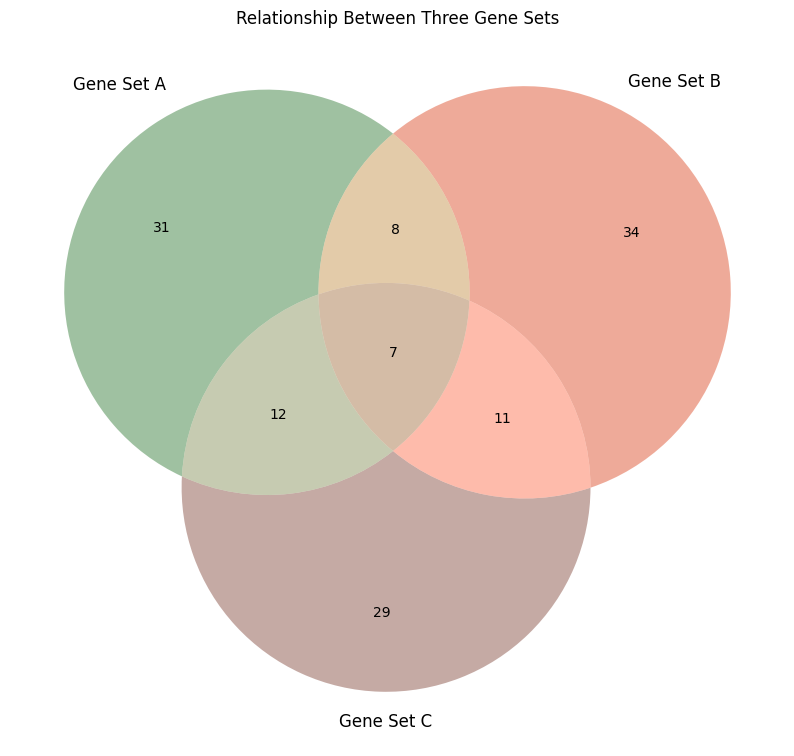

In [14]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from collections import Counter
# 将列表转换为集合
set_a = set(c4.columns)
set_b = set(c11.columns)
set_c = set(c34.columns)

# 创建图形
plt.figure(figsize=(10,10))

# 绘制韦恩图
cluster_colors=['#4b6aa8','#3ca0cf','#c376a7','#ad98c3','#408444',
             '#53738c','#a25087','#a78982','#a9c2cb','#92699e',
             '#d69971','#df5734','#6c408e','#ac6894','#d4c2db',
             '#537eb7','#83ab8e','#ece399','#405993','#cc7f73',
             '#b95055','#d5bb72','#bc9a7f','#e0cfda','#d8a0c0',
             '#e6b884','#b05545','#d69a55','#64a776','#cbdaa9',
             '#efd2c9','#da6f6d','#ebb1a4','#a44e89','#8c564b',
             '#b85292','#6d6fa0','#8d689d','#c8c7e1','#d25774',
             '#c49abc','#a5a9b0','#927c9a','#9f8d89','#72567a',
             '#63a3b8','#c4daec','#61bada','#b7deea','#e29eaf',
             '#4490c4','#e6e2a3','#de8b36','#c4612f','#9a70a8',
             '#76a2be','#cea5c7','#c6adb0','#9d3b62','#2d3462', "#FF420E", "#FFBB00"]
venn3([set_a, set_b, set_c], ('Gene Set A', 'Gene Set B', 'Gene Set C'), set_colors=[cluster_colors[4], cluster_colors[11], cluster_colors[34]], alpha=0.5)

# 设置标题
plt.title("Relationship Between Three Gene Sets")

# 显示图形
plt.savefig('./th_ctx_cluster_gene/venn.pdf', format='pdf')

In [218]:
c4.columns.tolist() + c11.columns.tolist()

['Glra1',
 'Onecut3',
 'Id2',
 'Adamts19',
 'Chrna4',
 'Ldb2',
 'Wnt4',
 'Vipr2',
 'Fgf10',
 'St6galnac5',
 'Ramp3',
 'Prss12',
 'Col6a1',
 'Epha6',
 'Tshz2',
 'Tpbg',
 'Ccdc3',
 'Lamp5',
 'Abhd12b',
 'Prkcd',
 'Caln1',
 'Cbln4',
 'Pnoc',
 'Cwh43',
 'Rreb1',
 'Nefh',
 'Epha3',
 'Calb2',
 'Npnt',
 'Necab1',
 'Myl4',
 'Cckbr',
 'Arsj',
 'Drd2',
 'Ptpru',
 'Cited1',
 'Rspo1',
 'Grp',
 'Epha8',
 'Htr2a',
 'Neurod6',
 'Htr2c',
 'Zfpm2',
 'Cdh6',
 'C1ql2',
 'Cux2',
 'Pcdh8',
 'Tnnt1',
 'Plpp4',
 'Lamc2',
 'Gbx2',
 'Ovol2',
 'Pde1a',
 'Cbln1',
 'Rorb',
 'Grid2ip',
 'Tmem132c',
 'Hs3st4',
 'Pkp2',
 'Glra1',
 'Adgrl2',
 'Rgs16',
 'Rprm',
 'Vipr2',
 'Ldb2',
 'Ramp3',
 'Col24a1',
 'Kcng1',
 'Nr4a2',
 'Gpr88',
 'Abhd12b',
 'Adam33',
 'Synpr',
 'Prkcd',
 'Sp9',
 'Grik3',
 'Igfn1',
 'Ankfn1',
 'Trhde',
 'Agt',
 'Cartpt',
 'Meis2',
 'Calb1',
 'Nell1',
 'Oprk1',
 'Tox',
 'Trpc6',
 'Calb2',
 'Plekhd1',
 'Ccn3',
 'Lypd1',
 'Cbln2',
 'Arsj',
 'Ptpru',
 'Coch',
 'Rab38',
 'Satb2',
 'Grp',
 'Tcap',
 'Bhlhe

In [225]:
print([i for i in c4.columns if i not in (c11.columns.tolist() + c34.columns.tolist())])

['Onecut3', 'Chrna4', 'Wnt4', 'Fgf10', 'St6galnac5', 'Prss12', 'Col6a1', 'Tshz2', 'Tpbg', 'Ccdc3', 'Pnoc', 'Cwh43', 'Rreb1', 'Nefh', 'Epha3', 'Npnt', 'Necab1', 'Cckbr', 'Drd2', 'Cited1', 'Epha8', 'Htr2a', 'Neurod6', 'Htr2c', 'C1ql2', 'Cux2', 'Pcdh8', 'Plpp4', 'Ovol2', 'Rorb', 'Tmem132c']


In [182]:
print(set(c4.columns) & set(c11.columns))

{'Vipr2', 'Prkcd', 'Arsj', 'Glra1', 'Cbln1', 'Grp', 'Tnnt1', 'Gbx2', 'Abhd12b', 'Cdh6', 'Ptpru', 'Ramp3', 'Calb2', 'Grid2ip', 'Ldb2'}


In [180]:
print(set(c4.columns) & set(c34.columns))

{'Hs3st4', 'Rspo1', 'Cbln4', 'Prkcd', 'Id2', 'Epha6', 'Ramp3', 'Calb2', 'Myl4', 'Pde1a', 'Caln1', 'Adamts19', 'Vipr2', 'Lamc2', 'Cbln1', 'Zfpm2', 'Gbx2', 'Lamp5', 'Tnnt1'}


In [179]:
print(set(c34.columns) & set(c11.columns))

{'Vipr2', 'Prkcd', 'Calb1', 'Cbln1', 'Col24a1', 'Adam33', 'Meis2', 'Gbx2', 'Igfn1', 'Tox', 'Coch', 'Ramp3', 'Calb2', 'Gpr88', 'Kcng1', 'Plekhd1', 'Tnnt1', 'Nr4a2'}


In [223]:
print(set(c34.columns) & set(c11.columns) & set(c4.columns))

{'Vipr2', 'Prkcd', 'Cbln1', 'Gbx2', 'Ramp3', 'Calb2', 'Tnnt1'}


cluster ctx to th conn compare

In [5]:
adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_1/zxw_symmetric_adj.npy')
print(adj.shape)

(250535, 250535)


In [6]:
adj

array([[1.46482056e-03, 1.52875370e-03, 1.26755067e-03, ...,
        5.08194937e-05, 1.00127200e-04, 8.53352588e-05],
       [1.52875370e-03, 1.44365519e-03, 1.34408089e-03, ...,
        4.87117037e-05, 9.50032855e-05, 7.98970040e-05],
       [1.26755067e-03, 1.34408089e-03, 1.05356081e-03, ...,
        4.60447459e-05, 8.87801448e-05, 7.36845773e-05],
       ...,
       [5.08194937e-05, 4.87117037e-05, 4.60447459e-05, ...,
        3.04320808e-05, 3.05465662e-05, 3.06512792e-05],
       [1.00127200e-04, 9.50032855e-05, 8.87801448e-05, ...,
        3.05465662e-05, 1.78689587e-05, 1.81205140e-05],
       [8.53352588e-05, 7.98970040e-05, 7.36845773e-05, ...,
        3.06512792e-05, 1.81205140e-05, 1.00894195e-05]])

In [7]:
adj_df = pd.DataFrame(adj)
adj_df

,0,1,2,3,4,5,6,7,8,9,...,250525,250526,250527,250528,250529,250530,250531,250532,250533,250534
0,0.001465,1.528754e-03,1.267551e-03,1.570595e-03,1.507101e-03,1.427545e-03,1.333705e-03,1.535697e-03,1.470528e-03,1.389526e-03,...,4.566004e-06,4.841144e-06,0.000005,0.000005,0.000010,0.000035,4.861852e-06,0.000051,0.000100,0.000085
1,0.001529,1.443655e-03,1.344081e-03,1.614101e-03,1.561447e-03,1.491001e-03,1.404081e-03,1.579720e-03,1.524891e-03,1.452421e-03,...,9.281647e-07,6.780744e-07,0.000001,0.000003,0.000009,0.000033,8.284778e-07,0.000049,0.000095,0.000080
2,0.001268,1.344081e-03,1.053561e-03,1.327558e-03,1.257014e-03,1.156483e-03,1.095403e-03,1.216033e-03,1.224671e-03,1.128417e-03,...,1.027830e-06,6.971314e-07,0.000001,0.000003,0.000009,0.000032,8.570606e-07,0.000046,0.000089,0.000074
3,0.001571,1.614101e-03,1.327558e-03,1.676217e-03,1.601663e-03,1.509839e-03,1.402938e-03,1.636726e-03,1.560503e-03,1.467295e-03,...,7.057784e-07,7.449492e-07,0.000001,0.000003,0.000010,0.000037,7.828975e-07,0.000054,0.000106,0.000093
4,0.001507,1.561447e-03,1.257014e-03,1.601663e-03,1.507719e-03,1.424693e-03,1.326709e-03,1.538160e-03,1.470193e-03,1.385618e-03,...,7.981774e-07,6.886839e-07,0.000001,0.000003,0.000010,0.000037,8.310057e-07,0.000053,0.000104,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250530,0.000035,3.342566e-05,3.151900e-05,3.744128e-05,3.681172e-05,3.570986e-05,3.413043e-05,3.839800e-05,3.771678e-05,3.653190e-05,...,1.226327e-04,1.526738e-04,0.000116,0.000107,0.000121,0.000038,1.928256e-04,0.000038,0.000038,0.000038
250531,0.000005,8.284778e-07,8.570606e-07,7.828975e-07,8.310057e-07,8.731052e-07,9.081960e-07,8.681074e-07,9.185677e-07,9.617521e-07,...,1.772496e-04,1.815847e-04,0.000185,0.000188,0.000191,0.000193,1.811477e-04,0.000194,0.000194,0.000193
250532,0.000051,4.871170e-05,4.604475e-05,5.356162e-05,5.267331e-05,5.113098e-05,4.895650e-05,5.401108e-05,5.308534e-05,5.148707e-05,...,1.228704e-04,1.531369e-04,0.000116,0.000107,0.000122,0.000038,1.939436e-04,0.000030,0.000031,0.000031
250533,0.000100,9.500329e-05,8.878014e-05,1.062380e-04,1.035992e-04,9.961541e-05,9.436618e-05,1.059683e-04,1.032337e-04,9.913287e-05,...,1.226021e-04,1.528134e-04,0.000117,0.000107,0.000123,0.000038,1.939922e-04,0.000031,0.000018,0.000018


In [8]:
adj_df.index = adata.obs['clusters'].values
adj_df.columns = adata.obs['clusters'].values
adj_df

,34,34,6,34,34,34,34,34,34,34,...,41,41,44,44,44,41,41,41,41,41
34,0.001465,1.528754e-03,1.267551e-03,1.570595e-03,1.507101e-03,1.427545e-03,1.333705e-03,1.535697e-03,1.470528e-03,1.389526e-03,...,4.566004e-06,4.841144e-06,0.000005,0.000005,0.000010,0.000035,4.861852e-06,0.000051,0.000100,0.000085
34,0.001529,1.443655e-03,1.344081e-03,1.614101e-03,1.561447e-03,1.491001e-03,1.404081e-03,1.579720e-03,1.524891e-03,1.452421e-03,...,9.281647e-07,6.780744e-07,0.000001,0.000003,0.000009,0.000033,8.284778e-07,0.000049,0.000095,0.000080
6,0.001268,1.344081e-03,1.053561e-03,1.327558e-03,1.257014e-03,1.156483e-03,1.095403e-03,1.216033e-03,1.224671e-03,1.128417e-03,...,1.027830e-06,6.971314e-07,0.000001,0.000003,0.000009,0.000032,8.570606e-07,0.000046,0.000089,0.000074
34,0.001571,1.614101e-03,1.327558e-03,1.676217e-03,1.601663e-03,1.509839e-03,1.402938e-03,1.636726e-03,1.560503e-03,1.467295e-03,...,7.057784e-07,7.449492e-07,0.000001,0.000003,0.000010,0.000037,7.828975e-07,0.000054,0.000106,0.000093
34,0.001507,1.561447e-03,1.257014e-03,1.601663e-03,1.507719e-03,1.424693e-03,1.326709e-03,1.538160e-03,1.470193e-03,1.385618e-03,...,7.981774e-07,6.886839e-07,0.000001,0.000003,0.000010,0.000037,8.310057e-07,0.000053,0.000104,0.000089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.000035,3.342566e-05,3.151900e-05,3.744128e-05,3.681172e-05,3.570986e-05,3.413043e-05,3.839800e-05,3.771678e-05,3.653190e-05,...,1.226327e-04,1.526738e-04,0.000116,0.000107,0.000121,0.000038,1.928256e-04,0.000038,0.000038,0.000038
41,0.000005,8.284778e-07,8.570606e-07,7.828975e-07,8.310057e-07,8.731052e-07,9.081960e-07,8.681074e-07,9.185677e-07,9.617521e-07,...,1.772496e-04,1.815847e-04,0.000185,0.000188,0.000191,0.000193,1.811477e-04,0.000194,0.000194,0.000193
41,0.000051,4.871170e-05,4.604475e-05,5.356162e-05,5.267331e-05,5.113098e-05,4.895650e-05,5.401108e-05,5.308534e-05,5.148707e-05,...,1.228704e-04,1.531369e-04,0.000116,0.000107,0.000122,0.000038,1.939436e-04,0.000030,0.000031,0.000031
41,0.000100,9.500329e-05,8.878014e-05,1.062380e-04,1.035992e-04,9.961541e-05,9.436618e-05,1.059683e-04,1.032337e-04,9.913287e-05,...,1.226021e-04,1.528134e-04,0.000117,0.000107,0.000123,0.000038,1.939922e-04,0.000031,0.000018,0.000018


In [9]:
cluster_means = adj_df.groupby(level=0).mean()
cluster_means

,34,34,6,34,34,34,34,34,34,34,...,41,41,44,44,44,41,41,41,41,41
0,3.721017e-05,2.084864e-05,1.842945e-05,2.969085e-05,2.242097e-05,2.162694e-05,1.923115e-05,2.027598e-05,1.935805e-05,1.638046e-05,...,5.163042e-05,3.792439e-05,6.604476e-05,1.439881e-04,1.838177e-04,2.133911e-04,3.493556e-05,3.539253e-04,3.397501e-04,2.075550e-04
1,2.630705e-04,1.589396e-04,1.530742e-04,2.062092e-04,1.552342e-04,1.507947e-04,1.521397e-04,1.490693e-04,1.439020e-04,1.387814e-04,...,6.361451e-05,5.692750e-05,6.668929e-05,6.389582e-05,7.618028e-05,6.849756e-05,5.048140e-05,9.322666e-05,7.344112e-05,4.509355e-05
2,8.444117e-05,1.595422e-04,1.326963e-04,9.378294e-05,1.453312e-04,9.609659e-05,5.533243e-05,7.805683e-05,5.263368e-05,2.790910e-05,...,8.695439e-07,8.706105e-07,9.496813e-07,9.838168e-07,1.003763e-06,9.164720e-07,8.708831e-07,9.598395e-07,1.192700e-06,1.041058e-06
3,1.887698e-06,1.873460e-06,1.851843e-06,1.888464e-06,1.888848e-06,1.880980e-06,1.865040e-06,1.886775e-06,1.885325e-06,1.875593e-06,...,1.020978e-06,1.139221e-06,1.021415e-06,1.045266e-06,1.042310e-06,1.017110e-06,1.067257e-06,1.041989e-06,1.056477e-06,1.083213e-06
4,4.338049e-04,2.731392e-04,2.699727e-04,4.299741e-04,2.827887e-04,2.806997e-04,2.861604e-04,3.075310e-04,2.738704e-04,2.737728e-04,...,1.299179e-05,1.329050e-05,1.616532e-05,1.629029e-05,1.311983e-05,8.747006e-06,1.174555e-05,1.147575e-05,1.230966e-05,8.421563e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,3.526188e-05,3.323795e-05,3.125116e-05,3.845048e-05,3.675402e-05,3.487781e-05,3.444350e-05,3.805541e-05,3.636901e-05,3.487506e-05,...,6.075161e-04,6.274788e-04,1.257685e-03,1.836668e-03,1.293995e-03,3.620476e-04,5.253589e-04,2.036790e-04,1.739377e-04,8.079879e-05
58,2.377199e-07,2.227832e-07,2.390731e-07,1.848870e-07,1.972410e-07,2.110990e-07,2.263786e-07,1.882146e-07,2.006984e-07,2.147337e-07,...,6.245965e-08,6.186111e-08,8.221107e-08,1.423500e-07,1.304728e-07,6.864732e-08,6.011885e-08,6.638668e-08,5.575309e-08,5.022517e-08
59,7.627631e-07,7.547492e-07,7.452623e-07,7.283247e-07,7.362141e-07,7.380202e-07,7.337636e-07,7.099932e-07,7.169533e-07,7.179766e-07,...,1.774702e-06,1.747956e-06,1.749806e-06,1.765019e-06,1.792389e-06,1.828722e-06,1.946848e-06,2.086332e-06,2.396127e-06,2.765144e-06
60,3.010249e-07,7.785373e-08,7.533491e-08,8.288314e-08,8.199868e-08,8.049095e-08,7.837129e-08,8.355942e-08,8.265535e-08,8.105834e-08,...,1.435622e-07,1.183282e-07,1.012031e-07,9.047870e-08,8.375662e-08,7.871168e-08,1.134194e-07,7.681838e-08,7.723725e-08,7.835216e-08


In [12]:
# cluster_means = cluster_means.T
cluster_means = cluster_means.groupby(level=0).mean()
cluster_means

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,1.059001e-03,3.910751e-04,6.883150e-06,0.000005,3.180381e-05,2.357782e-04,9.799176e-06,8.546878e-05,2.050871e-04,6.089934e-07,...,2.398384e-05,0.000002,7.877747e-07,5.731816e-07,0.000011,0.000062,1.707372e-06,1.024118e-06,5.834650e-07,9.290281e-07
1,3.910751e-04,6.973001e-04,3.653836e-05,0.000015,2.575613e-04,3.696927e-04,7.006233e-05,4.909999e-04,3.214769e-04,4.998244e-07,...,1.681587e-04,0.000003,1.880422e-06,7.143009e-07,0.000053,0.000069,4.284965e-06,8.025030e-07,1.602818e-06,8.148649e-07
2,6.883150e-06,3.653836e-05,9.389814e-04,0.000074,9.050683e-05,6.653089e-05,8.950411e-05,5.868282e-05,4.530963e-05,9.715819e-07,...,1.590771e-05,0.000012,7.377802e-07,9.251624e-07,0.000093,0.000004,1.714621e-06,1.447031e-06,1.114255e-06,7.646061e-07
3,4.835237e-06,1.548791e-05,7.396732e-05,0.001622,3.901117e-06,3.432422e-05,2.166609e-06,2.929185e-05,3.078479e-06,1.727928e-06,...,4.862446e-06,0.000085,2.648258e-04,9.602076e-07,0.000078,0.000005,2.655799e-04,1.420634e-06,4.995873e-04,1.675891e-04
4,3.180381e-05,2.575613e-04,9.050683e-05,0.000004,1.549489e-03,8.839655e-05,3.034326e-04,6.277800e-04,4.059533e-04,8.755775e-07,...,2.165855e-04,0.000002,3.936950e-07,5.890431e-07,0.000019,0.000069,2.920385e-06,1.198724e-06,3.653203e-07,2.310973e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,6.196508e-05,6.920779e-05,4.407155e-06,0.000005,6.946278e-05,2.708089e-05,1.264511e-05,1.408939e-04,7.747067e-05,8.998906e-05,...,4.157046e-05,0.000021,1.751157e-06,5.806187e-05,0.000021,0.000897,2.948308e-06,9.068390e-05,1.847045e-06,1.780690e-06
58,1.707372e-06,4.284965e-06,1.714621e-06,0.000266,2.920385e-06,5.019956e-06,8.331533e-07,2.892879e-06,1.336775e-06,2.689122e-07,...,1.651451e-06,0.000015,7.900043e-05,2.352338e-07,0.000022,0.000003,8.349231e-04,5.452197e-07,1.182285e-04,3.446687e-05
59,1.024118e-06,8.025030e-07,1.447031e-06,0.000001,1.198724e-06,1.187017e-06,5.700981e-07,4.509015e-06,2.784661e-06,1.146619e-04,...,1.480765e-06,0.000005,8.656828e-07,3.093124e-03,0.000004,0.000091,5.452197e-07,4.774965e-05,8.881614e-07,1.477552e-06
60,5.834650e-07,1.602818e-06,1.114255e-06,0.000500,3.653203e-07,2.852297e-06,1.598476e-07,1.537767e-06,4.026694e-07,4.929104e-07,...,3.763374e-07,0.000013,1.783834e-03,2.006424e-07,0.000005,0.000002,1.182285e-04,8.881614e-07,2.318649e-03,2.050258e-03


In [17]:
cluster_means.to_csv('./cluster_to_cluster_conn.csv')

In [29]:
os.getcwd()

'/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw'

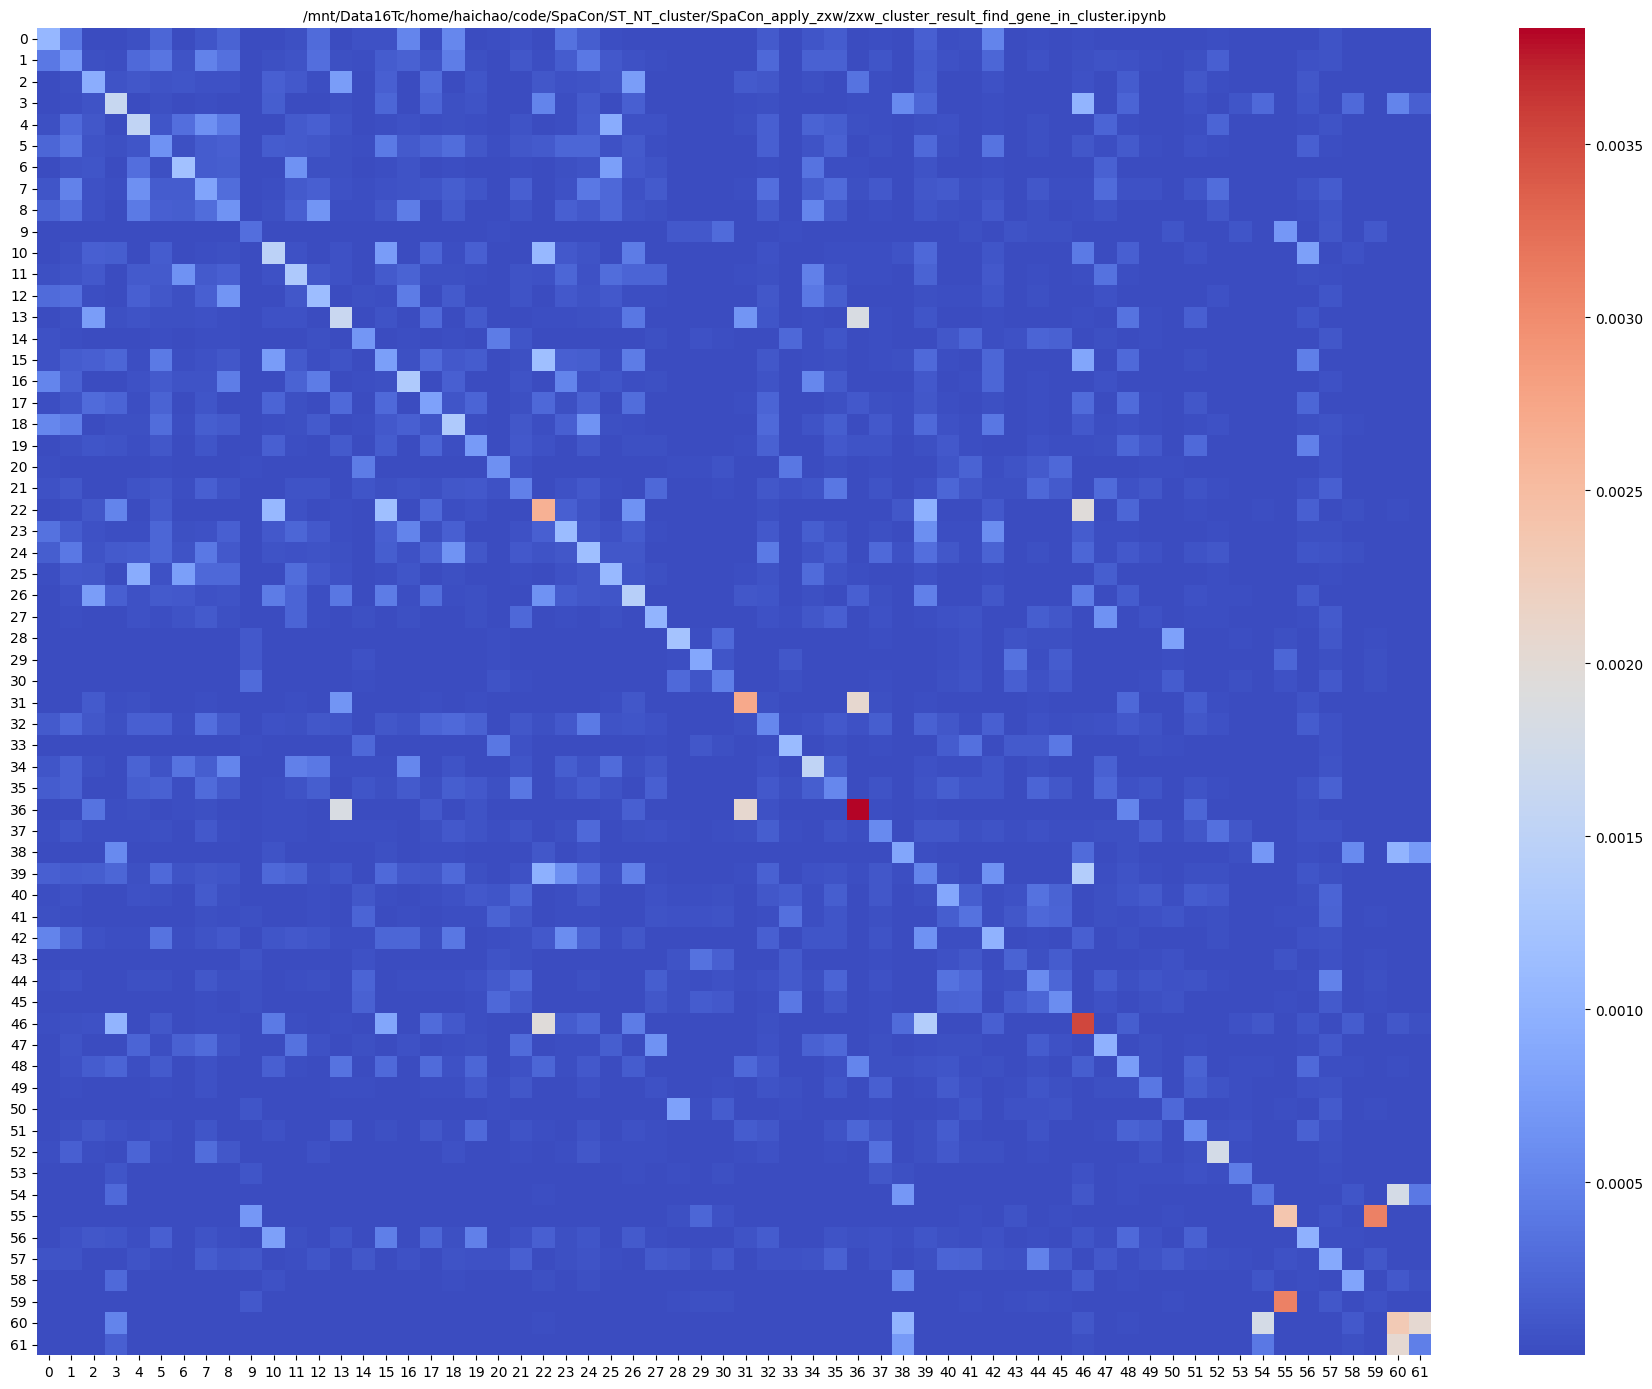

In [33]:
plt.figure(figsize=(18,14))
sns.heatmap(cluster_means, cmap='coolwarm')
plt.title('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_NT_cluster/SpaCon_apply_zxw/zxw_cluster_result_find_gene_in_cluster.ipynb', fontsize=10)
plt.tight_layout()
plt.savefig('./fig/cluster_to_cluster_conn.pdf', format='pdf')

In [97]:
adata.obs['spot_num'] = [i for i in range(len(adata))]
adata.obs

,x_section_mean,x,y,z,section,NT_index,Cells_id,clusters,region,spot_num
17372,78.263674,78.452677,13.191827,18.160718,Zhuang-ABCA-1.089,17372,128774508912159308594581401235556383390_213121...,34,SSp-bfd1,0
17373,78.263674,78.448536,12.772759,18.915082,Zhuang-ABCA-1.089,17373,12178582400974066355828759918371219171_1406625...,34,SSp-bfd1,1
17374,78.263674,78.460662,13.212311,19.882828,Zhuang-ABCA-1.089,17374,10734369597807854619513434572440734574,6,SSp-bfd2/3,2
17375,78.263674,78.465620,14.023911,17.072386,Zhuang-ABCA-1.089,17375,115214074142609000172622102162174041648_131417...,34,SSp-bfd1,3
17376,78.263674,78.470710,13.995189,17.975140,Zhuang-ABCA-1.089,17376,183961703904731256008311122839342242648_307079...,34,SSp-bfd1,4
...,...,...,...,...,...,...,...,...,...,...
394003,97.196243,98.977526,65.263353,56.949818,Zhuang-ABCA-1.110,394003,12621493196285474387197628572622199676_1970675...,41,RM,250530
394004,97.196243,99.518549,60.744262,57.295587,Zhuang-ABCA-1.110,394004,155741763330095796244671955834043113952_183460...,41,RM,250531
394009,97.196243,98.677011,67.327207,56.954466,Zhuang-ABCA-1.110,394009,110024137764232152397180345422396202379_200215...,41,tb,250532
394016,97.196243,98.350011,69.706568,56.969685,Zhuang-ABCA-1.110,394016,101969430796686017933403669639918335523_109373...,41,tb,250533


In [106]:
th = adata[(adata.obs['region'].isin(th_regions)) & (adata.obs['clusters'].isin(['4', '11', '34']))]
th_index = th.obs['spot_num'].tolist()
# th_index

In [107]:
ctx = adata[(adata.obs['region'].str.startswith(tuple(ctx_regions))) & (adata.obs['clusters'].isin(['4', '11', '34']))]
ctx_index = ctx.obs['spot_num'].tolist()

In [112]:
ctx.obs

,x_section_mean,x,y,z,section,NT_index,Cells_id,clusters,region,spot_num
17372,78.263674,78.452677,13.191827,18.160718,Zhuang-ABCA-1.089,17372,128774508912159308594581401235556383390_213121...,34,SSp-bfd1,0
17373,78.263674,78.448536,12.772759,18.915082,Zhuang-ABCA-1.089,17373,12178582400974066355828759918371219171_1406625...,34,SSp-bfd1,1
17375,78.263674,78.465620,14.023911,17.072386,Zhuang-ABCA-1.089,17375,115214074142609000172622102162174041648_131417...,34,SSp-bfd1,3
17376,78.263674,78.470710,13.995189,17.975140,Zhuang-ABCA-1.089,17376,183961703904731256008311122839342242648_307079...,34,SSp-bfd1,4
17377,78.263674,78.477137,14.107068,18.974909,Zhuang-ABCA-1.089,17377,112767040300550428131589034900926514319_152848...,34,SSp-bfd2/3,5
...,...,...,...,...,...,...,...,...,...,...
40995,97.196243,96.660655,31.023830,12.952902,Zhuang-ABCA-1.110,40995,12433625893152767593473902931501788803_2101328...,11,VISpor2/3,248621
40996,97.196243,96.654173,31.016684,13.787381,Zhuang-ABCA-1.110,40996,107410745428877565066517038467093494548_128406...,11,VISpor2/3,248622
40997,97.196243,96.664643,31.941197,10.691328,Zhuang-ABCA-1.110,40997,262101628401073831609040332601383823896_300175...,11,VISpor1,248623
40998,97.196243,96.652059,32.140267,12.103665,Zhuang-ABCA-1.110,40998,108821933270165579538148869090492875201_142696...,11,VISpor2/3,248624


In [108]:
ctx2th_conn = adj[ctx_index][:, th_index]
ctx2th_conn.shape

(12142, 1445)

In [130]:
ctx2th_conn_df = pd.DataFrame(ctx2th_conn)
ctx2th_conn_df

,0,1,2,3,4,5,6,7,8,9,...,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444
0,0.000750,0.000543,0.001244,0.000916,0.000971,0.000896,0.000722,0.000667,0.000304,0.000412,...,0.000279,0.000139,0.000073,0.000064,0.000078,0.000060,0.000136,0.000158,0.000227,0.000269
1,0.000724,0.000534,0.001159,0.000862,0.000917,0.000836,0.000680,0.000628,0.000295,0.000419,...,0.000262,0.000131,0.000091,0.000079,0.000080,0.000068,0.000120,0.000143,0.000206,0.000242
2,0.000775,0.000546,0.001397,0.001007,0.001067,0.001004,0.000793,0.000735,0.000275,0.000392,...,0.000304,0.000157,0.000085,0.000081,0.000101,0.000078,0.000171,0.000194,0.000272,0.000317
3,0.000759,0.000545,0.001311,0.000958,0.001013,0.000945,0.000756,0.000698,0.000284,0.000402,...,0.000291,0.000147,0.000077,0.000072,0.000090,0.000070,0.000153,0.000175,0.000248,0.000290
4,0.000738,0.000540,0.001225,0.000906,0.000959,0.000885,0.000716,0.000660,0.000291,0.000411,...,0.000276,0.000138,0.000086,0.000075,0.000079,0.000065,0.000136,0.000158,0.000225,0.000263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12137,0.000251,0.000119,0.000983,0.000545,0.000874,0.000539,0.000414,0.000461,0.004313,0.003306,...,0.000032,0.000550,0.000509,0.000502,0.000388,0.000510,0.000452,0.000541,0.000716,0.000546
12138,0.000243,0.000114,0.000945,0.000524,0.000840,0.000520,0.000401,0.000443,0.004210,0.003242,...,0.000031,0.000538,0.000495,0.000486,0.000377,0.000484,0.000434,0.000517,0.000695,0.000536
12139,0.000267,0.000130,0.001066,0.000590,0.000956,0.000584,0.000438,0.000505,0.004489,0.003390,...,0.000036,0.000573,0.000541,0.000544,0.000411,0.000589,0.000498,0.000608,0.000762,0.000558
12140,0.000261,0.000126,0.001036,0.000573,0.000927,0.000567,0.000428,0.000489,0.004437,0.003361,...,0.000034,0.000565,0.000530,0.000529,0.000402,0.000563,0.000482,0.000584,0.000746,0.000553


In [132]:
ctx2th_conn_df.index = ctx.obs['clusters'].values
ctx2th_conn_df.columns = th.obs['clusters'].values
ctx2th_conn_df

,4,34,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
34,0.000750,0.000543,0.001244,0.000916,0.000971,0.000896,0.000722,0.000667,0.000304,0.000412,...,0.000279,0.000139,0.000073,0.000064,0.000078,0.000060,0.000136,0.000158,0.000227,0.000269
34,0.000724,0.000534,0.001159,0.000862,0.000917,0.000836,0.000680,0.000628,0.000295,0.000419,...,0.000262,0.000131,0.000091,0.000079,0.000080,0.000068,0.000120,0.000143,0.000206,0.000242
34,0.000775,0.000546,0.001397,0.001007,0.001067,0.001004,0.000793,0.000735,0.000275,0.000392,...,0.000304,0.000157,0.000085,0.000081,0.000101,0.000078,0.000171,0.000194,0.000272,0.000317
34,0.000759,0.000545,0.001311,0.000958,0.001013,0.000945,0.000756,0.000698,0.000284,0.000402,...,0.000291,0.000147,0.000077,0.000072,0.000090,0.000070,0.000153,0.000175,0.000248,0.000290
34,0.000738,0.000540,0.001225,0.000906,0.000959,0.000885,0.000716,0.000660,0.000291,0.000411,...,0.000276,0.000138,0.000086,0.000075,0.000079,0.000065,0.000136,0.000158,0.000225,0.000263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,0.000251,0.000119,0.000983,0.000545,0.000874,0.000539,0.000414,0.000461,0.004313,0.003306,...,0.000032,0.000550,0.000509,0.000502,0.000388,0.000510,0.000452,0.000541,0.000716,0.000546
11,0.000243,0.000114,0.000945,0.000524,0.000840,0.000520,0.000401,0.000443,0.004210,0.003242,...,0.000031,0.000538,0.000495,0.000486,0.000377,0.000484,0.000434,0.000517,0.000695,0.000536
11,0.000267,0.000130,0.001066,0.000590,0.000956,0.000584,0.000438,0.000505,0.004489,0.003390,...,0.000036,0.000573,0.000541,0.000544,0.000411,0.000589,0.000498,0.000608,0.000762,0.000558
11,0.000261,0.000126,0.001036,0.000573,0.000927,0.000567,0.000428,0.000489,0.004437,0.003361,...,0.000034,0.000565,0.000530,0.000529,0.000402,0.000563,0.000482,0.000584,0.000746,0.000553


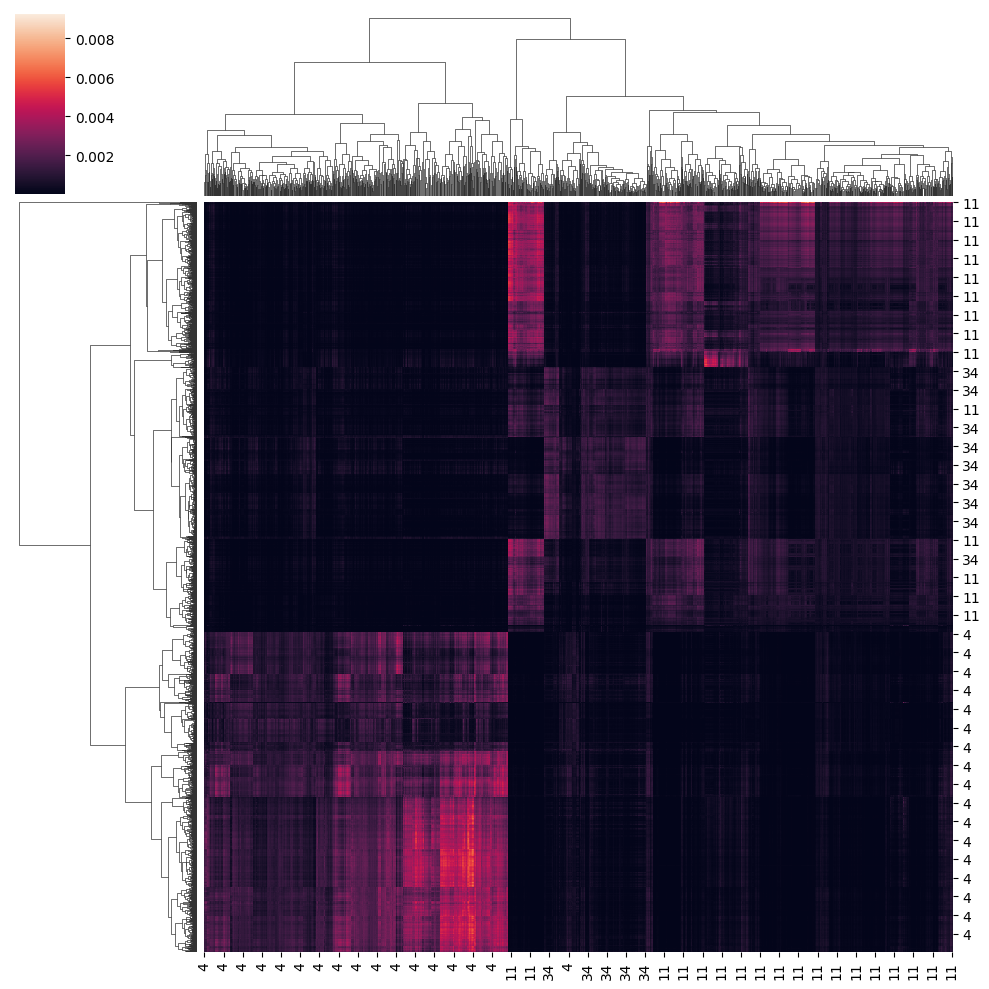

In [133]:
sns.clustermap(ctx2th_conn_df)

In [127]:
ctx2th_conn_df['ctx_clusters'] = ctx.obs['clusters'].values
ctx2th_conn_df = ctx2th_conn_df.groupby('ctx_clusters').mean()
ctx2th_conn_df

,0,1,2,3,4,5,6,7,8,9,...,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444
ctx_clusters,,,,,,,,,,,,,,,,,,,,,
4,0.000960,0.000633,0.000615,0.000780,0.000804,0.000734,0.000898,0.000756,0.000107,0.000137,...,0.000232,0.000029,0.000006,0.000009,0.000015,0.000005,0.000011,0.000013,0.000023,0.000035
11,0.000326,0.000309,0.001661,0.001032,0.001487,0.001264,0.000887,0.001016,0.000698,0.000585,...,0.000647,0.001212,0.001294,0.001344,0.001280,0.001444,0.001360,0.001516,0.001470,0.001398
34,0.000780,0.000903,0.000864,0.001007,0.000778,0.000932,0.001003,0.000696,0.000157,0.000175,...,0.000574,0.000100,0.000064,0.000065,0.000107,0.000072,0.000148,0.000145,0.000184,0.000165


In [128]:
ctx2th_conn_df = ctx2th_conn_df.T
ctx2th_conn_df['th_clusters'] = th.obs['clusters'].values
ctx2th_conn_df = ctx2th_conn_df.groupby('th_clusters').mean()
ctx2th_conn_df

ctx_clusters,4,11,34
th_clusters,,,
4,0.001671,0.000091,0.000190
11,0.000137,0.001252,0.000401
34,0.000198,0.000273,0.001065


<AxesSubplot:xlabel='th_clusters', ylabel='ctx_clusters'>

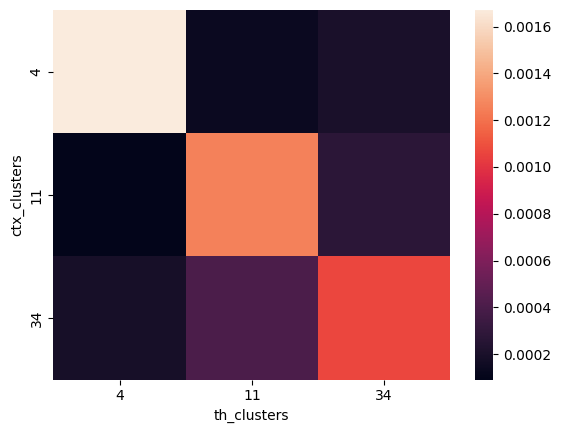

In [129]:
sns.heatmap(ctx2th_conn_df.T)

#### other regions

In [117]:
cluster = '13'
sec = 'Zhuang-ABCA-1.099'

In [118]:
# 2. 准备数据
# X = adata.layers['adj_gene'].A  # 基因表达矩阵
X = adata.X.A  # 基因表达矩阵
y = adata.obs['clusters'].values  # 类别标签
# 3. 标准化数据
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X
# 将类别标签转换为二分类问题，假设类别1为1，其它类别为0
y_binary = np.where(y == cluster, 1, 0)

# 4. 建立PLS模型
pls = PLSRegression(n_components=10)  # 你可以调整n_components
pls.fit(X, y_binary)

# 5. 分析结果
# PLS系数可以帮助你找出重要的基因
coefficients = pls.coef_.flatten()
# coefficients = np.abs(pls.coef_.ravel())

gene_names = adata.var_names
ctx_gene_importance = pd.DataFrame({
    'Gene': gene_names,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

In [119]:
# 计算重要性的平均值和标准差
importance_mean = ctx_gene_importance['Importance'].mean()
importance_std = ctx_gene_importance['Importance'].std()
# 设置阈值为平均值加上一个标准差
# threshold = importance_mean + importance_std
# threshold = ctx_gene_importance['Importance'].quantile(0.97)
# 选择重要性高于阈值的基因
# ctx_genes = ctx_gene_importance[ctx_gene_importance['Importance'] > threshold]
ctx_genes =  ctx_gene_importance.sort_values(by='Importance', ascending=False).head(30)
# 按重要性降序排序
ctx_genes = ctx_genes.sort_values('Importance', ascending=False)

# 只使用选定的基因重新计算加权表达
X_selected = X[:, [list(gene_names).index(gene) for gene in ctx_genes['Gene']]]
coefficients_selected = ctx_genes['Coefficient'].values
weighted_expression = np.dot(X_selected, coefficients_selected)
# 将加权表达向量添加到原始数据中
scaler = StandardScaler()
adata.obs['other_Expression'] = X_scaled = scaler.fit_transform(weighted_expression.reshape(-1, 1))
len(ctx_genes)

30

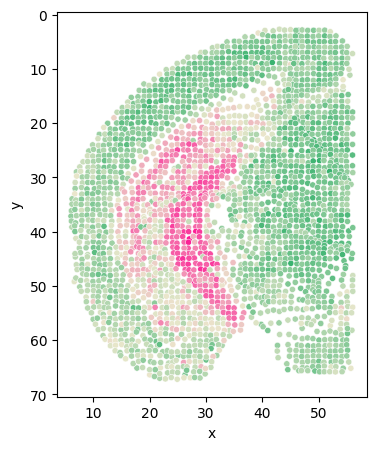

In [120]:
# sec =  'Zhuang-ABCA-1.113'
adata_s = adata[adata.obs['section'] == sec]
# fig, ax = plt.subplots(figsize=(4, 5))
# sc.pl.spatial(adata_s, color=['other_Expression'], spot_size=1, cmap=color_self, ax=ax)

df = pd.DataFrame({
    'x': adata_s.obs['z'],
    'y': adata_s.obs['y'],
    # 'expression': adata_s[:, 'Zfhx4'].layers['adj_gene'].A.flatten()  # 展平为一维数组
    'expression': adata_s.obs['other_Expression']  # 展平为一维数组
})
# 创建散点图
plt.figure(figsize=(4, 5))  # 调整为所需的图像大小
scatter_plot = sns.scatterplot(data=df, x='x', y='y', hue='expression', palette=color_self, s=20, legend=False)  # 's' 为点的大小
plt.gca().invert_yaxis()
# scatter_plot.set_title('Gene Expression Spatial Plot')

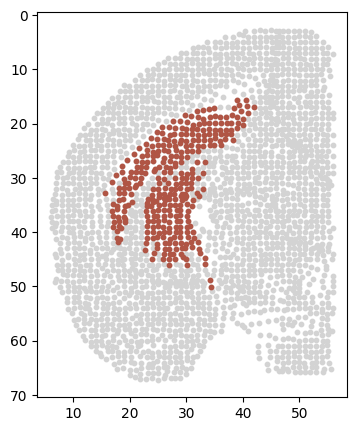

In [127]:
# Class_i = '34'
# section = 'Zhuang-ABCA-1.087'
cluster_i_section_i_adata = adata[(adata.obs['clusters'] == cluster) & (adata.obs['section'] == sec)]
cluster_i_section_i_adata = cluster_i_section_i_adata[cluster_i_section_i_adata.obs['z'] < 56]

back = adata[adata.obs['section'] == sec]
back = back[back.obs['z'] < 56]

fig = plt.figure(figsize=(4, 5))
plt.scatter(back.obs['z'], back.obs['y'], s=10, c='#D3D3D3')
plt.scatter(cluster_i_section_i_adata.obs['z'], cluster_i_section_i_adata.obs['y'], s=10, c=cluster_colors[int(cluster)+13])
plt.gca().invert_yaxis()